# Timing distance calculations

I want to create 3-4 simple models in order to show the effect of the distance algorithm for Kriging and how it can be applied to Gempy models. In general I think 3 Layers should be fine, cutting out the central one. Keeping all in the same size around max 5000 grid points gives reasonable calculation times.
1) flat horizontal 
2) anticline 
3) recumbent anticline
4) layer pinching out ?
5) should be something like a fault

In [1]:
# These lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['MKL_THREADING_LAYER'] = 'GNU'

# Importing GemPy, which takes really long
import gempy as gp

# Importing auxiliary libraries
import numpy as np
import matplotlib 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import pandas as pd

C:\Users\Jan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [56]:
geo_data = gp.create_data([0,1000,0,20,0,1000],resolution=[100,5,100], 
                        path_o = "C:/Users/Jan/gempy/notebooks/prototype_notebooks/JanThesis/Jan_thesis_model1_orientations_slice.csv", path_i = "C:/Users/Jan/gempy/notebooks/prototype_notebooks/JanThesis/Jan_thesis_model1_interfaces_slice.csv")


In [57]:
gp.set_series(geo_data, {"Strat_Series": ('rock2','rock1'),"Basement_Series":('basement')},order_series = ['Strat_Series','Basement_Series'],
                       order_formations=np.array(['rock2','rock1','basement']), verbose=0)

In [58]:
colormodel = {'basement':'#ffa700','rock1':'#d62d20','rock2':'#0057e7','rock3':'#008744','fault':'#17202a'}
geo_data.set_colors(colormodel)
cmap = matplotlib.colors.ListedColormap(list(geo_data.formations['color']))
#geo_data.formations

In [59]:
geo_data.set_colors(colormodel)

,value,formation_number,color
rock2,1,1,#0057e7
rock1,2,2,#d62d20
basement,3,3,#ffa700


In [60]:
#%matplotlib inline
#gp.get_sequential_pile(geo_data)

In [61]:
#%matplotlib inline
#gp.plotting.plot_data(geo_data, direction='y')

In [62]:
interp_data = gp.InterpolatorData(geo_data, u_grade=[1], output='geology', compile_theano=True, theano_optimizer='fast_compile')

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0


In [63]:
lith_block, fault_block = gp.compute_model(interp_data)

C:\Users\Jan\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2320: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


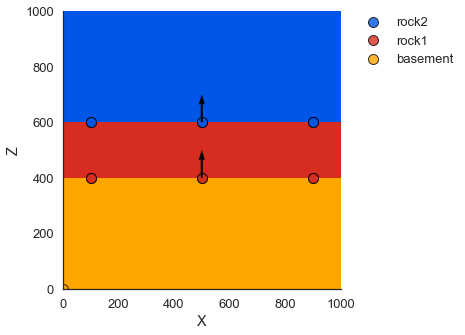

In [64]:
%matplotlib inline
gp.plotting.plot_section(geo_data, lith_block[0], cell_number=0,
                         direction='y', plot_data=True, cmap=cmap, norm=None)

plt.savefig(fname='Model1_pure', edgecolor='black')

In [65]:
import gempy.utils.Kriging_Jan as krige

In [66]:
d = {'X': [500, 500], 'Y': [10, 10], 'Z': [500,500], 'Property': [20, 20]}
data_field = pd.DataFrame(data=d)
print(data_field)

     X   Y    Z  Property
0  500  10  500        20
1  500  10  500        20


In [67]:
test = krige.Kriging(data_field, lith_block, geo_data, formation_number=2, kriging_type='OK', distance_type='deformed_B', an_factor=1, var_par=(200,50,1))

initializing: 0.008549213409423828
Step1 0.004007577896118164
Step2 -0.7510621547698975
Step3 -1.4982120990753174
Step4 -3.687464475631714
distance precalculation: 5.950853586196899
submatrix extraction: 0.01673412322998047
distance Matrices: 1.7789952754974365
kriging calculation: 2.2646262645721436
Negative Variances: 0
Out of: 10001


In [68]:
print(len(test.grid_dataframe))

10000


In [69]:
coord = test.result_coord[:3]
result = test.kriging_result[1]
combined = np.vstack((coord, result))
combined = np.swapaxes(combined,0,1)

combined_cut = np.where(combined[:,1]<10)[0]
combined_cut = combined[combined_cut]
combined_cut = combined_cut[:,[0,2,3]]

In [47]:
colormodel = {'basement':'#696969','rock1':'#A0A0A0','rock2':'#BEBEBE','rock3':'#008744','fault':'#17202a'}

geo_data.set_colors(colormodel)

cmap = matplotlib.colors.ListedColormap(list(geo_data.formations['color']))

geo_data.formations

,value,formation_number,color
rock2,1,1,#BEBEBE
rock1,2,2,#A0A0A0
basement,3,3,#696969


In [48]:
from numpy import linspace, meshgrid
from matplotlib.mlab import griddata

def grid(x, y, z, resX=100, resY=100):
    "Convert 3 column data to matplotlib grid"
    xi = linspace(min(x), max(x), resX)
    yi = linspace(min(y), max(y), resY)
    Z = griddata(x, y, z, xi, yi, interp='linear')
    X, Y = meshgrid(xi, yi)
    return X, Y, Z

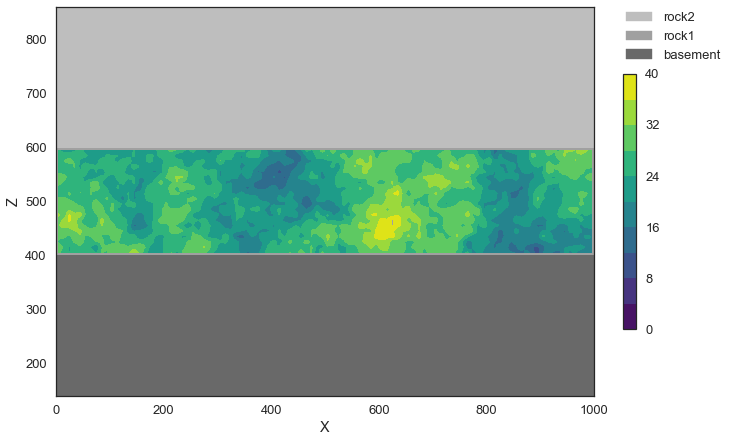

In [49]:
X, Y, Z = grid(combined_cut[:,0], combined_cut[:,1], combined_cut[:,2])

norm=matplotlib.colors.Normalize(vmin=0, vmax=40)
v = np.linspace(0, 40,11, endpoint=True)

a = plt.contourf(X, Y, Z, v, cmap='viridis', norm=norm)

gp.plotting.plot_section(geo_data, lith_block[0], cell_number=1,
                         direction='y', plot_data=False, cmap=cmap, norm=None)

plt.axis('equal')
plt.xlim(0,1000)
plt.ylim(200,800)

plt.colorbar(a, orientation='vertical', fraction=0.022, pad=0.05)

#plt.savefig(fname='Basic_SGSfield_200_50_1_deformedB', edgecolor='black', bbox_inches='tight')
#fig.tight_layout()

In [50]:
mean = np.mean(test.kriging_result[1])
max_val = np.max(test.kriging_result[1])
min_val = np.min(test.kriging_result[1])
variance = np.var(test.kriging_result[1])
std = np.sqrt(variance)


Text(0.5,1,'Histogram using 50 bins')

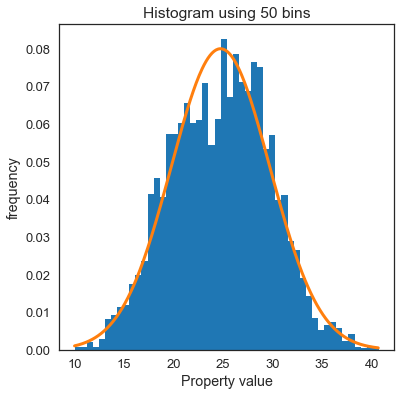

In [51]:
import scipy

fig = plt.figure(figsize = (6, 6)) 
#show histogram (normal and cumulative)
bin_amount = 50

x_vals = np.arange(min_val, max_val, 0.1)

plt.hist(test.kriging_result[1], bins=bin_amount, normed=True);
plt.plot(x_vals, scipy.stats.norm.pdf(x_vals, mean, std), lw = 3)
plt.xlabel("Property value")
plt.ylabel("frequency")
plt.title('Histogram using %i bins' %bin_amount)

#plt.savefig(fname='Basic_SGSfield_200_50_1_deformedB_hist', edgecolor='black', bbox_inches='tight')

In [52]:
'''
coord_dist = test.result_coord[:3]
dist_plt = test.dist_matrix_plt[:,1]
combined = np.vstack((coord_dist, dist_plt))
combined = np.swapaxes(combined,0,1)
combined_cut = np.where(combined[:,1]<10)[0]
combined_cut = combined[combined_cut]
combined_cut = combined_cut[:,[0,2,3]]

X, Y, Z = grid(combined_cut[:,0], combined_cut[:,1], combined_cut[:,2])

norm=matplotlib.colors.Normalize(vmin=0, vmax=600)
v = np.linspace(0, 600,11, endpoint=True)

c = plt.scatter(x=coord_dist[0,0], y=coord_dist[2,0], c='black', s=50, marker='o',zorder=3)

a = plt.contourf(X, Y, Z, v, cmap='plasma_r', norm=norm)
b = plt.contourf(X, Y, Z, v, cmap='plasma_r', norm=norm)

gp.plotting.plot_section(geo_data, lith_block[0], cell_number=1,
                         direction='y', plot_data=False, cmap=cmap, norm=None)

plt.colorbar(a, orientation='vertical', fraction=0.019, pad=0.06)

plt.axis('equal')
plt.xlim(0,1000)
plt.ylim(200,800)

plt.savefig(fname='Distancefield__deformedA_modelA_an=1', edgecolor='black', bbox_inches='tight')
'''

"\ncoord_dist = test.result_coord[:3]\ndist_plt = test.dist_matrix_plt[:,1]\ncombined = np.vstack((coord_dist, dist_plt))\ncombined = np.swapaxes(combined,0,1)\ncombined_cut = np.where(combined[:,1]<10)[0]\ncombined_cut = combined[combined_cut]\ncombined_cut = combined_cut[:,[0,2,3]]\n\nX, Y, Z = grid(combined_cut[:,0], combined_cut[:,1], combined_cut[:,2])\n\nnorm=matplotlib.colors.Normalize(vmin=0, vmax=600)\nv = np.linspace(0, 600,11, endpoint=True)\n\nc = plt.scatter(x=coord_dist[0,0], y=coord_dist[2,0], c='black', s=50, marker='o',zorder=3)\n\na = plt.contourf(X, Y, Z, v, cmap='plasma_r', norm=norm)\nb = plt.contourf(X, Y, Z, v, cmap='plasma_r', norm=norm)\n\ngp.plotting.plot_section(geo_data, lith_block[0], cell_number=1,\n                         direction='y', plot_data=False, cmap=cmap, norm=None)\n\nplt.colorbar(a, orientation='vertical', fraction=0.019, pad=0.06)\n\nplt.axis('equal')\nplt.xlim(0,1000)\nplt.ylim(200,800)\n\nplt.savefig(fname='Distancefield__deformedA_modelA_a

In [53]:
# Sampling
def random_sampling(data):
    #print(len(data))
    rand_pos = np.random.randint(0,len(data),50)
    #print(rand_pos)
    #print(rand_pos.shape)
    samples = data[rand_pos]
    return samples

In [54]:
samples = random_sampling(combined)

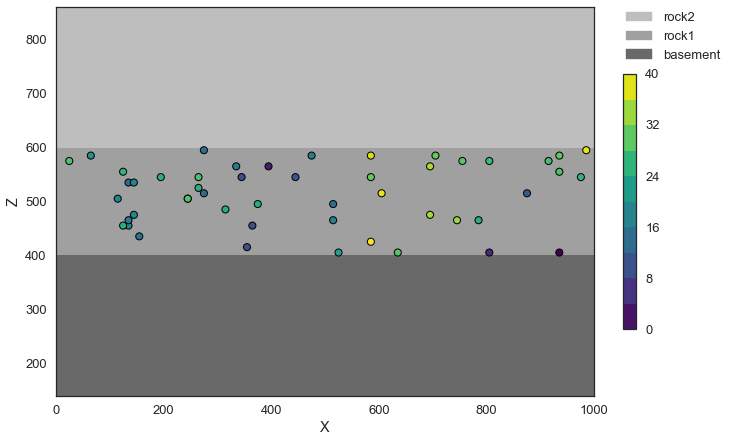

In [55]:
gp.plotting.plot_section(geo_data, lith_block[0], cell_number=1,
                         direction='y', plot_data=False, cmap=cmap, norm=None)

plt.scatter(x=samples[:,0], y=samples[:,2], c=samples[:,3], s=50, cmap='viridis', linewidths=1, edgecolors='black')

plt.axis('equal')
plt.xlim(0,1000)
plt.ylim(200,800)

plt.colorbar(a, orientation='vertical', fraction=0.022, pad=0.05)

plt.savefig(fname='Basic_SGSfield_200_50_1_samples', edgecolor='black')

In [25]:
d = {'X': samples[:,0], 'Y': samples[:,1], 'Z': samples[:,2], 'Property': samples[:,3]}
data_field = pd.DataFrame(data=d)
#print(data_field)

In [26]:
simulation = krige.Kriging(data_field, lith_block, geo_data, formation_number=2, kriging_type='UK', distance_type='deformed_A')

initializing: 0.014101982116699219
Step1 0.0
Step2 -0.10424017906188965
Step3 -0.0697793960571289
Step4 -0.03962397575378418
distance precalculation: 0.22384285926818848
submatrix extraction: 0.005509614944458008
distance Matrices: 0.10416364669799805
kriging calculation: 0.24770140647888184
Negative Variances: 0
Out of: 640


In [27]:
coord = simulation.result_coord[:3]
result = simulation.kriging_result[1]
combined = np.vstack((coord, result))
combined = np.swapaxes(combined,0,1)

combined_cut = np.where(combined[:,1]<10)[0]
combined_cut = combined[combined_cut]
combined_cut = combined_cut[:,[0,2,3]]

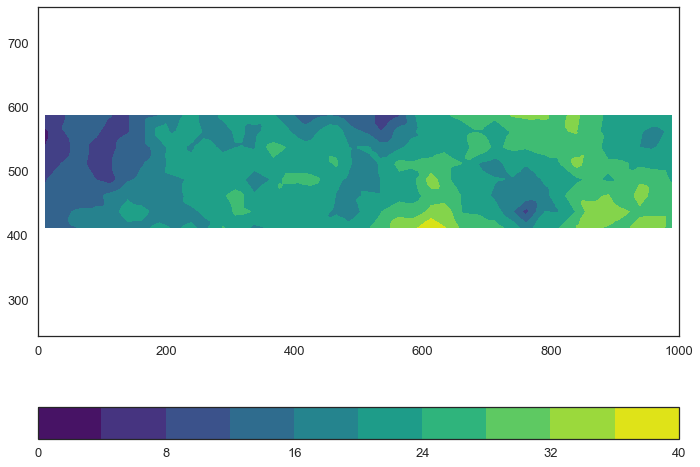

In [28]:
X, Y, Z = grid(combined_cut[:,0], combined_cut[:,1], combined_cut[:,2])

fig = plt.figure(figsize=(10, 7))

plt.contourf(X, Y, Z, cmap='viridis')

plt.axis('equal')
plt.xlim(0,1000)
plt.ylim(300,700)

fig.colorbar(a, orientation='horizontal')
fig.tight_layout()

In [29]:
print(test.grid_dataframe.head())

      X     Y      Z  lith     scalar  fault
0  12.5  0.25  412.5   2.0  41.125198    0.0
1  12.5  0.25  437.5   2.0  41.152977    0.0
2  12.5  0.25  462.5   2.0  41.180756    0.0
3  12.5  0.25  487.5   2.0  41.208534    0.0
4  12.5  0.25  512.5   2.0  41.236309    0.0


In [30]:
print(lith_block[0].shape)

print(geo_data.grid.values[:, 0].shape)

(3200,)
(3200,)


In [31]:
d = {'X': geo_data.grid.values[:, 0], 'Y': geo_data.grid.values[:, 1], 'Z': geo_data.grid.values[:, 2],
     'lithology': lith_block[0], 'scalar field value': lith_block[1]}
dataframe = pd.DataFrame(data=d)
print(dataframe.head())

      X     Y      Z  lithology  scalar field value
0  12.5  0.25   12.5        3.0           40.680756
1  12.5  0.25   37.5        3.0           40.708534
2  12.5  0.25   62.5        3.0           40.736309
3  12.5  0.25   87.5        3.0           40.764088
4  12.5  0.25  112.5        3.0           40.791866


In [32]:
# create the dataframe and populate with data
d = {'X': geo_data.grid.values[:, 0], 'Y': geo_data.grid.values[:, 1], 'Z': geo_data.grid.values[:, 2],
    'lithology': lith_block[0], 'scalar field value': lith_block[1], 'fault block': fault_block[0]}


dataframe = pd.DataFrame(data=d)

IndexError: index 0 is out of bounds for axis 0 with size 0